# Greedy RKO

1.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import normalize
from time import process_time

In [2]:
def calculate_resid(A,x,b):
  r = (np.linalg.norm(np.matmul(A,x)-b))**2
  return r

In [3]:
def calculate_ap(Xk,Xnew):
  e = (np.linalg.norm(Xk-Xnew))**2
  return e

In [4]:
def calc_FLOP(iteration, cond, rand_flop_rate, skm_flop_rate):
  flop = [0];
  for i in range(iteration):
    if cond[i] == "RK":
      flop.append(flop[-1] + rand_flop_rate)
    else:
      flop.append(flop[-1] + skm_flop_rate)

  return flop

In [5]:
def rse(xk, xs):
  rse = ((np.linalg.norm(xk-xs))**2) / (np.linalg.norm(xs))**2
  return rse

## RK Function

In [6]:
def RK(A,x,y, TOL = 0.5 * 10**-6):
  k=0
  m, n = A.shape
  x0 = np.zeros(n)
  x_lst = [x0]
  rse_lst = []
  rse_val = rse(x0, x)
  rse_lst.append(rse_val)
  k+=1
  while True:
    p = (np.linalg.norm(A, axis = 1) / np.linalg.norm(A))**2
    i = np.random.choice(range(m), p=p)
    ai = A[i,:]
    xk = x0 + (((y[i]- ai@x0) / np.linalg.norm(ai)**2) * np.transpose(ai))
    x_lst.append(xk)
    x0 = xk
    rse_val = rse(x0, x)
    rse_lst.append(rse_val)
    k+=1
    if rse_val < TOL or k == 100000:
      break
  return k, rse_lst

## RKO Function

In [7]:
def RKO(A,x,y, TOL = 0.5 * 10**-6):
  k = 0
  m,n = A.shape
  x0 = np.zeros(n)
  rse_lst = []
  rse_val = rse(x0, x)
  rse_lst.append(rse_val)
  x_lst = [x0]
  row_lst = []
  i0 = np.random.choice(range(m))
  row_lst.append(i0)
  k+=1
  a0 = A[i0,:]
  x1 = x0 + ((y[i0] - a0@x0) / np.linalg.norm(a0)**2) * a0
  while True:
    i1 = np.random.choice(range(m))
    if i1 == i0:
      i1 = np.random.choice(range(m))
    elif i1 != i0:
      break
  row_lst.append(i1)
  a1 = A[i1,:]
  x2 = x1 + ((y[i1] - a1@x1) / (np.linalg.norm(a1)**2 - (((a0@a1)**2)/np.linalg.norm(a0)**2))) * ((a1 - (a0@a1)/np.linalg.norm(a0)**2) * a0)
  x0 = x2
  i_k1 = i1
  while True:
    ik = i_k1
    while True:
      i_k1 = np.random.choice(range(m))
      if i_k1 == row_lst[-1] or i_k1 == row_lst[-2]:
        i_k1 = np.random.choice(range(m))
      elif i_k1 != row_lst[-1] and i_k1 != row_lst[-2]:
        break
    row_lst.append(i_k1)
    ai = A[ik,:] #ai_k-1
    ai_k = A[i_k1,:] #ai_k
    D_ik = ai_k@ai
    r = y[i_k1] - ai_k@x0
    w = ai_k - ((D_ik / np.linalg.norm(ai)**2) * ai)
    h_ik = np.linalg.norm(w)**2
    alpha = r / h_ik
    xk = x0 + alpha*w
    x0 = xk
    rse_val = rse(x0, x)
    rse_lst.append(rse_val)
    k+=1
    if rse_val < TOL or k == 100000:
      break
  return k, rse_lst

## Greedy Kaczmarz

In [8]:
def GK(A, x, y, TOL = 0.5 * 10**-6):
  k=0
  m, n = A.shape
  x0 = np.zeros(n)
  x_lst = [x0]
  rse_lst = []
  rse_val = rse(x0, x)
  rse_lst.append(rse_val)
  k+=1

  while True:
    r = []
    for i in range(m):
      resid = np.transpose(A[i,:])@x0 - y[i]
      r.append([i,np.abs(resid)])
    [i,r] = max(r,key = lambda x : x[1])
    ai = A[i,:]
    xk = x0 + (((y[i]- ai@x0) / np.linalg.norm(ai)**2) * np.transpose(ai))
    x_lst.append(xk)
    x0 = xk
    rse_val = rse(x0, x)
    rse_lst.append(rse_val)
    k+=1
    if rse_val < TOL or k == 100000:
      break

  return k, x_lst, rse_lst

## Greedy KO

In [69]:
def GKO(A, x, y, TOL = 0.5 * 10**-6):
  k=0
  rk_count = 0
  rko_count = 0
  row_lst = []
  rse_lst = []
  m, n = A.shape
  x0 = np.zeros(n)
  x_lst = [x0]
  rse_val = rse(x0, x)
  rse_lst.append(rse_val)
  [ik, i_k1] = np.random.choice(range(m), 2)  
  row_lst.extend([ik, i_k1])
  a1 = A[ik,:]
  x1 = x0 + ((y[ik] - a1@x0) / np.linalg.norm(a1)**2) * np.transpose(a1)
  x_lst.append(x1)
  row_lst.append(i_k1)
  a2 = A[i_k1,:]
  x2 = x1 + ((y[i_k1] - a2@x1) / (np.linalg.norm(a2)**2 - (((a1@a2)**2)/np.linalg.norm(a1)**2))) * ((a2 - (a1@a2)/np.linalg.norm(a1)**2) * a1)
  x_lst.append(x2)
  x0 = x2
  k+=1

  while True:
    t_lst = []
    ik = row_lst[-1]
    for i in range(m):
      if i != ik:
        r = y[i] - A[i,:]@x_lst[-1]
        w = A[i,:] - ( ( A[ik,:]@A[i,:] / np.linalg.norm(A[ik,:])**2 ) * A[ik,:] )
        t = abs(r) / np.linalg.norm(w)**2
        t_lst.append([i,t])
    # Choose the row with max t
    [i_k1,t_lst] = max(t_lst,key = lambda x : x[1])
    row_lst.append(i_k1)
    #print(i_k1)
    # Do RKO with the i
    ai = A[ik,:] # a_k-1
    ai_k = A[i_k1,:] # a_k
    D_ik = ai@ai_k
    r = y[i_k1] - ai_k@x0
    w = ai_k - ((D_ik / np.linalg.norm(ai)**2) * ai)
    h_ik = np.linalg.norm(w)**2
    alpha = r / h_ik
    xk = x0 + alpha*w
    x0 = xk
    x_lst.append(x0)
    rse_val = rse(x0, x)
    rse_lst.append(rse_val)
    #print(rse_val)
    k+=1

    if rse_val < TOL or k == 100000:
      break

  return k, x_lst, rse_lst

In [68]:
def GKO2(A, x, y, TOL = 0.5 * 10**-6):
  k=0
  rk_count = 0
  rko_count = 0
  row_lst = []
  rse_lst = []
  m, n = A.shape
  x0 = np.zeros(n)
  x_lst = [x0]
  rse_val = rse(x0, x)
  rse_lst.append(rse_val)
  [ik, i_k1] = np.random.choice(range(m), 2)  
  row_lst.extend([ik, i_k1])
  a1 = A[ik,:]
  x1 = x0 + ((y[ik] - a1@x0) / np.linalg.norm(a1)**2) * np.transpose(a1)
  x_lst.append(x1)
  row_lst.append(i_k1)
  a2 = A[i_k1,:]
  x2 = x1 + ((y[i_k1] - a2@x1) / (np.linalg.norm(a2)**2 - (((a1@a2)**2)/np.linalg.norm(a1)**2))) * ((a2 - (a1@a2)/np.linalg.norm(a1)**2) * a1)
  x_lst.append(x2)
  x0 = x2
  k+=1

  while True:
    a_lst = []
    ik = row_lst[-1]
    for i in range(m):
      if i != ik:
        r = y[i] - A[i,:]@x0
        w = A[i,:] -  A[i,:]@A[ik,:] / np.linalg.norm(A[ik,:])**2  * A[ik,:] 
        t = r / np.linalg.norm(w)**2
        a_lst.append([i,t,w])
    # Choose the row with max t
    [i_k1,t,w] = max(a_lst,key = lambda x : x[1])
    row_lst.append(i_k1)
    # Do RKO with the i
    xk = x0 + t*w
    x0 = xk
    x_lst.append(x0)
    rse_val = rse(x0, x)
    print(rse_val)
    rse_lst.append(rse_val)
    k+=1

    if rse_val < TOL or k == 100000:
      break

  return k, x_lst, rse_lst

## Greedy KO (Angle)

In [87]:
def GKO3(A, x, y, TOL = 0.5 * 10**-6):
  k=0
  rk_count = 0
  rko_count = 0
  row_lst = []
  rse_lst = []
  m, n = A.shape
  x0 = np.zeros(n)
  x_lst = [x0]
  rse_val = rse(x0, x)
  rse_lst.append(rse_val)
  [ik, i_k1] = np.random.choice(range(m), 2)  
  row_lst.extend([ik, i_k1])
  a1 = A[ik,:]
  x1 = x0 + ((y[ik] - a1@x0) / np.linalg.norm(a1)**2) * np.transpose(a1)
  x_lst.append(x1)
  row_lst.append(i_k1)
  a2 = A[i_k1,:]
  x2 = x1 + ((y[i_k1] - a2@x1) / (np.linalg.norm(a2)**2 - (((a1@a2)**2)/np.linalg.norm(a1)**2))) * ((a2 - (a1@a2)/np.linalg.norm(a1)**2) * a1)
  x_lst.append(x2)
  x0 = x2
  k+=1

  while True:
    angle_lst = []
    ik = row_lst[-1]
    ai = A[ik,:]
    for i in range(m):
      if i != ik:
        ai_k = A[i,:]
        theta = math.acos((ai@ai_k)/(np.linalg.norm(ai)*np.linalg.norm(ai_k)))
        angle_lst.append([i,theta])
    # Choose the row with max t
    [i_k1,angle_lst] = min(angle_lst,key = lambda x : x[1])
    print(i_k1)
    row_lst.append(i_k1)
    #print(i_k1)
    # Do RKO with the i
    ai = A[ik,:] # a_k-1
    ai_k = A[i_k1,:] # a_k
    D_ik = ai@ai_k
    r = y[i_k1] - ai_k@x0
    w = ai_k - ((D_ik / np.linalg.norm(ai)**2) * ai)
    h_ik = np.linalg.norm(w)**2
    alpha = r / h_ik
    xk = x0 + alpha*w
    x0 = xk
    x_lst.append(x0)
    rse_val = rse(x0, x)
    rse_lst.append(rse_val)
    print(rse_val)
    k+=1

    if rse_val < TOL or k == 100000:
      break

  return k, x_lst, rse_lst

## Gaussian Experiments

In [83]:
A = np.random.randn(5000,500)
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x
x0 = np.zeros(500)

In [89]:
GKO3(A,x,y)

1098
0.9992765761937594
2133
0.9977046108944175
1098
0.9977046108944179
2133
0.9977046108944179
1098
0.9977046108944179
2133
0.9977046108944179
1098
0.9977046108944179
2133
0.9977046108944175
1098
0.9977046108944175
2133
0.9977046108944179
1098
0.9977046108944179
2133
0.9977046108944175
1098
0.9977046108944175
2133
0.9977046108944179
1098
0.9977046108944179
2133
0.9977046108944175
1098
0.9977046108944175
2133
0.9977046108944179
1098
0.9977046108944179
2133
0.9977046108944175
1098
0.9977046108944175
2133
0.9977046108944179
1098
0.9977046108944179
2133
0.9977046108944175
1098
0.9977046108944175
2133
0.9977046108944179
1098
0.9977046108944179
2133
0.9977046108944175
1098
0.9977046108944175
2133
0.9977046108944179
1098
0.9977046108944179
2133
0.9977046108944175
1098
0.9977046108944175
2133
0.9977046108944179
1098
0.9977046108944179
2133
0.9977046108944175
1098
0.9977046108944175
2133
0.9977046108944179
1098
0.9977046108944179
2133
0.9977046108944175
1098
0.9977046108944175
2133
0.997704610

KeyboardInterrupt: ignored

In [91]:
gko1 = GKO(A, x, y)
gk1 = GK(A,x,y)

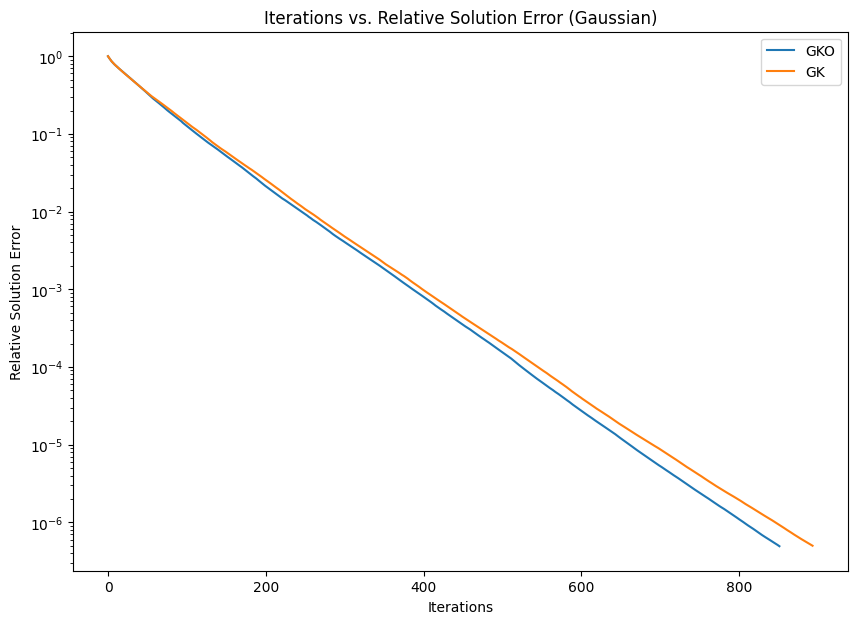

In [92]:
plt.figure(figsize=(10,7))

plt.semilogy(np.arange(gko1[0]), gko1[2], label = 'GKO')
#plt.semilogy(np.arange(gko1_2[0]), gko1_2[2], label = 'GKO (Angle)')
plt.semilogy(np.arange(gk1[0]), gk1[2], label = 'GK')
#plt.semilogy(np.arange(rk[0]), rk[1], label = 'RK')
#plt.semilogy(np.arange(rko[0]), rko[1], label = 'RKO')

plt.xlabel('Iterations')
plt.ylabel('Relative Solution Error')
plt.title('Iterations vs. Relative Solution Error (Gaussian)')
plt.legend()

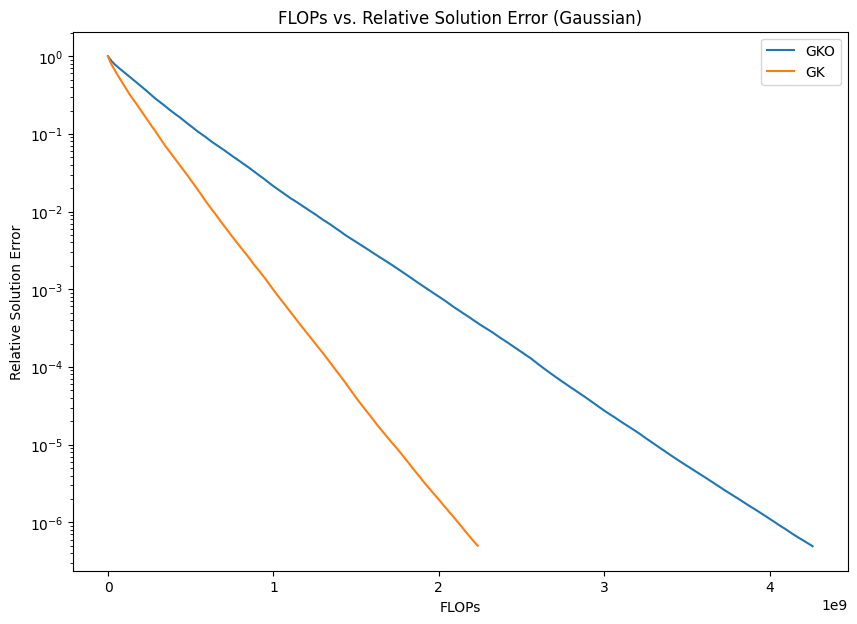

In [93]:
# FLOP
plt.figure(figsize=(10,7))
flop_gko = 2 * 5000 * 500
flop_gk = 5000 * 500
plt.semilogy(np.linspace(0, gko1[0]*flop_gko, gko1[0]), gko1[2], label = 'GKO')
#plt.semilogy(np.linspace(0, gko1_2[0]*flop_gko, gko1_2[0]), gko1_2[2], label = 'GKO (Angle)')
plt.semilogy(np.linspace(0, gk1[0]*flop_gk, gk1[0]), gk1[2], label = 'GK')
plt.xlabel('FLOPs')
plt.ylabel('Relative Solution Error')
plt.title('FLOPs vs. Relative Solution Error (Gaussian)')
plt.legend()

## Uniform Experiments

In [94]:
#uniform
A = np.random.rand(5000,500)
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x

In [95]:
gko2 = GKO(A, x, y)
#gko2_2 = GKO3(A, x, y)
gk2 = GK(A,x,y)

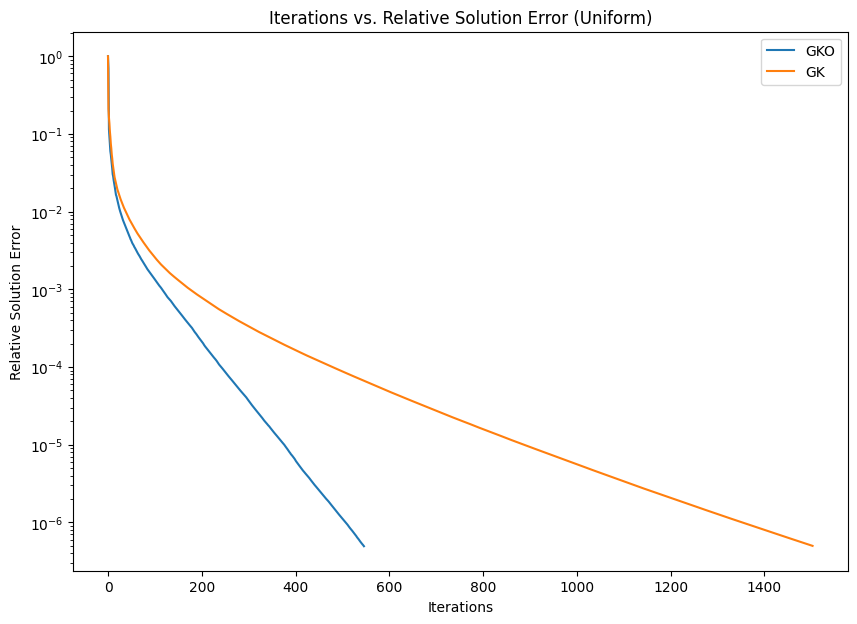

In [96]:
plt.figure(figsize=(10,7))

plt.semilogy(np.arange(gko2[0]), gko2[2], label = 'GKO')
#plt.semilogy(np.arange(gko2_2[0]), gko2_2[2], label = 'GKO (Angle)')
plt.semilogy(np.arange(gk2[0]), gk2[2], label = 'GK')
#plt.semilogy(np.arange(rk[0]), rk[1], label = 'RK')
#plt.semilogy(np.arange(rko[0]), rko[1], label = 'RKO')

plt.xlabel('Iterations')
plt.ylabel('Relative Solution Error')
plt.title('Iterations vs. Relative Solution Error (Uniform)')
plt.legend()

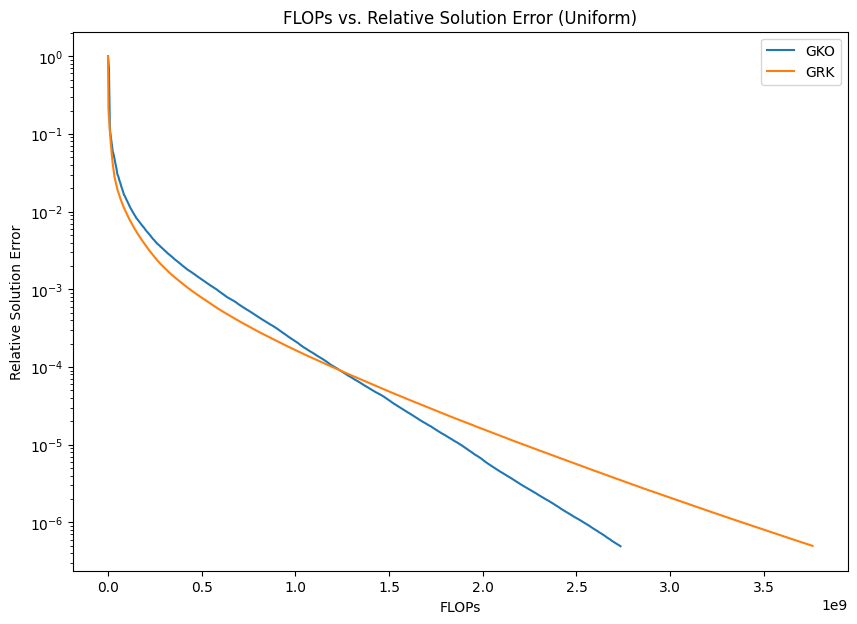

In [97]:
# FLOP
plt.figure(figsize=(10,7))
flop_gko = 2 * 5000 * 500
flop_gk = 5000 * 500
plt.semilogy(np.linspace(0, gko2[0]*flop_gko, gko2[0]), gko2[2], label = 'GKO')
#plt.semilogy(np.linspace(0, gko2_2[0]*flop_gko, gko2_2[0]), gko2_2[2], label = 'GKO (Angle)')
plt.semilogy(np.linspace(0, gk2[0]*flop_gk, gk2[0]), gk2[2], label = 'GRK')
plt.xlabel('FLOPs')
plt.ylabel('Relative Solution Error')
plt.title('FLOPs vs. Relative Solution Error (Uniform)')
plt.legend()

## 50-50 Gaussian/Uniform System

In [98]:
A1 = np.random.rand(2500,500)
A2 = np.random.randn(2500,500)
A1 = np.concatenate((A1, A2))
A2 = normalize(A1, axis=1, norm='l2')
x = np.ones(500)
y1 = A1 @ x
y2 = A2 @ x

In [99]:
gko3 = GKO(A2,x, y2)
#gko3_2 = GKO3(A2,x, y2)
gk3 = GK(A2,x,y2)

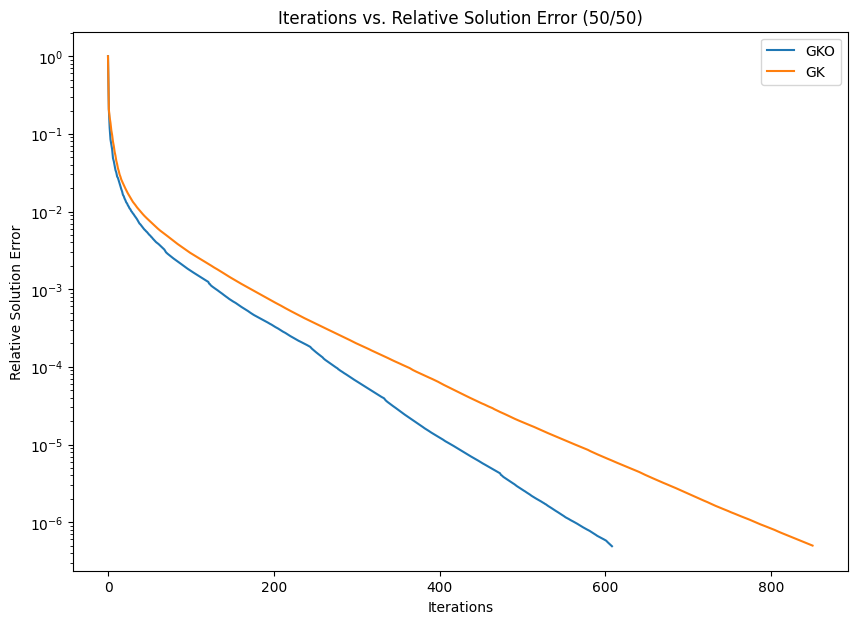

In [100]:
plt.figure(figsize=(10,7))

plt.semilogy(np.arange(gko3[0]), gko3[2], label = 'GKO')
#plt.semilogy(np.arange(gko3_2[0]), gko3_2[2], label = 'GKO (Angle)')
plt.semilogy(np.arange(gk3[0]), gk3[2], label = 'GK')
#plt.semilogy(np.arange(rk[0]), rk[1], label = 'RK')
#plt.semilogy(np.arange(rko[0]), rko[1], label = 'RKO')

plt.xlabel('Iterations')
plt.ylabel('Relative Solution Error')
plt.title('Iterations vs. Relative Solution Error (50/50)')
plt.legend()

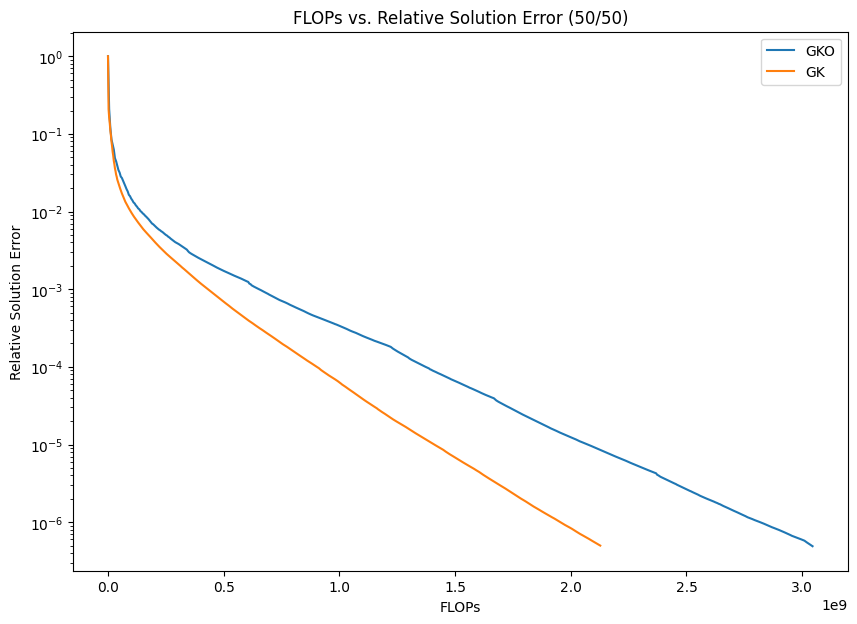

In [101]:
# FLOP
plt.figure(figsize=(10,7))
flop_gko = 2 * 5000 * 500
flop_gk = 5000 * 500
plt.semilogy(np.linspace(0, gko3[0]*flop_gko, gko3[0]), gko3[2], label = 'GKO')
#plt.semilogy(np.linspace(0, gko3_2[0]*flop_gko, gko3_2[0]), gko3_2[2], label = 'GKO (Angle)')
plt.semilogy(np.linspace(0, gk3[0]*flop_gk, gk3[0]), gk3[2], label = 'GK')
plt.xlabel('FLOPs')
plt.ylabel('Relative Solution Error')
plt.title('FLOPs vs. Relative Solution Error (50/50)')
plt.legend()